In [1]:
from pathlib import Path
root_path = Path().cwd().parent.absolute()
import sys 
sys.path.append(str(root_path))

In [2]:
import torch as torch
from torch.distributions import MultivariateNormal
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

import numpy as np
import matplotlib.pyplot as plt

import parametric_pushforward.data_sets as toy_data
from parametric_pushforward.parametric_mlp import order_state_to_tensor, MLP,torch_wrapper,ParameterizedMLP,ParameterizedWrapper
from parametric_pushforward.setup_density_path import get_activation

from flow_matching.train_fm import ACTIVATION_FNS


import parametric_pushforward.parametric_ode_solvers
from torchdyn.core import NeuralODE



from geomloss import SamplesLoss

import yaml
import os


Successfully patched Parametric_Euler and Parametric_Midpoint


In [3]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)

In [4]:
exp_dir = str(root_path)+'/models/gaussian1_d[50,128,4,softplus]'
yaml_path = os.path.join(exp_dir,'config.yaml')
with open(yaml_path) as file:
    config = yaml.load(file,Loader = yaml.FullLoader)

In [5]:
data_set = config['data']['type']
input_dim = config['model']['input_dim']
hidden_dim = config['model']['hidden_dim']
num_layers = config['model']['num_layers']
activation = ACTIVATION_FNS[config['model']['activation_fn']]
time_varying = config['model']['time_varying']

arch = [input_dim,hidden_dim,num_layers,activation]

model = MLP(arch=arch,time_varying=time_varying)

state_path = os.path.join(exp_dir,'final.pth') #  checkpoint_999.pth #final
state_tensor = torch.load(state_path,map_location=device)['model_state_dict']

model.load_state_dict(state_dict=state_tensor)

model = torch_wrapper(model)


In [6]:
activation = get_activation(config['model']['activation_fn'])
arch = [input_dim,hidden_dim,num_layers,activation]

In [7]:
theta = order_state_to_tensor(state_tensor)
parametric_model = ParameterizedWrapper(ParameterizedMLP(arch,time_varying=time_varying),theta=theta)

In [8]:
referece = MultivariateNormal(loc = torch.zeros(input_dim).to(device),covariance_matrix=torch.eye(input_dim).to(device))

t_node = torch.linspace(0,1,10).to(device)

In [9]:
node = NeuralODE(model,solver = 'midpoint').to(device)
parametric_node = NeuralODE(parametric_model,solver = 'midpoint').to(device)


In [20]:
bs = 7000

z = referece.sample((bs,)).to(device)
trajecotry = node.trajectory(z,t_span=t_node)
par_trajectory = parametric_node.trajectory(z,t_span=t_node)

node_samples = trajecotry[-1].detach().cpu()
par_node_samples = par_trajectory[-1].detach().cpu()

true_samples = torch.from_numpy(toy_data.inf_train_gen(data=data_set,batch_size=bs,dim = config['model']['input_dim']))

In [21]:
data_set

'gaussian1_d'

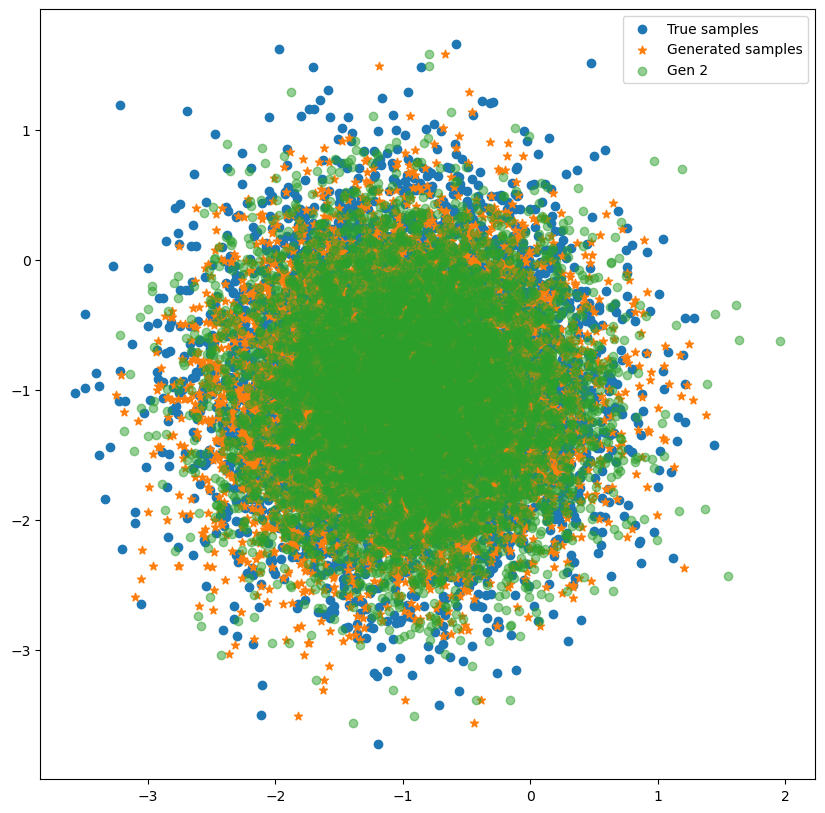

In [22]:
fig = plt.figure(figsize=(10,10))
plt.scatter(true_samples[:,10],true_samples[:,1],label = 'True samples')
plt.scatter(node_samples[:,10],node_samples[:,1],label='Generated samples',marker = '*')
plt.scatter(par_node_samples[:,0],par_node_samples[:,1],label = 'Gen 2',alpha=.5)

plt.legend()

In [23]:
loss = SamplesLoss(loss = 'sinkhorn', p = 2, blur = 0.05)
L = loss(node_samples,true_samples)

NameError: name 'generic_logsumexp' is not defined

In [19]:
L.item()


12.860199928283691